# XgBoost Pipeline
---

This notebook was to test running detection algorithm using XgBoost Regressor as the final model for the BMI detection app. This file will perform embeddings and training for regressor. This model will then be used in app.py to be usd in real time.

In [1]:
# !pip install --quiet pandas numpy matplotlib seaborn torch torchvision facenet-pytorch insightface pytorch-metric-learning xgboost scikit-learn opencv-python onnxruntime mozuma

In [ ]:
import os
import ssl
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

from xgboost import XGBRegressor
from facenet_pytorch import InceptionResnetV1, MTCNN

import torch

# Ignore SSL certificate verification
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
# Paths
IMAGE_DIR = "data/Images"
existing_image_files = os.listdir(IMAGE_DIR)

# Load CSV
df = pd.read_csv("data/data.csv").drop(columns=["Unnamed: 0"])
print(f"Loaded {df.shape[0]} rows from CSV")

# Filter out rows with missing image files
df = df[df["name"].isin(existing_image_files)]
print(f"Filtered to {df.shape[0]} rows with existing images")

# Split into training and testing sets
training_data_df = df[df['is_training'] == 1]
testing_data_df = df[df['is_training'] == 0]
print(f"Training data shape: {training_data_df.shape}")
print(f"Testing data shape: {testing_data_df.shape}")
df.head(5)

Loaded 4206 rows from CSV
Filtered to 3962 rows with existing images
Training data shape: (3210, 4)
Testing data shape: (752, 4)


,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
6,25.845588,Female,1,img_6.bmp


In [5]:
# Model setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(image_size=160, margin=20, device=device)

In [ ]:
def process_row(row):
    """
    Helper function to process each row of the DataFrame using with multi-threading.
    """
    img_path = os.path.join(IMAGE_DIR, row['name'])
    try:
        img = Image.open(img_path).convert('RGB')
        face = mtcnn(img)
        if face is not None:
            face = face.unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = resnet(face).cpu().numpy().flatten()
            return embedding, row['bmi'], row['name']
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
    return None

def multi_threaded_embedding_extraction(df):
    """
    Embedding extraction for each image with multi-threading.
    """
    # Initialize lists for embeddings and labels
    X = []
    y = []
    filenames = []
    
    # Use ThreadPoolExecutor to process images in parallel
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(process_row, row) for _, row in df.iterrows()]

        for future in tqdm(as_completed(futures), total=len(futures)):
            result = future.result()
            if result:
                embedding, bmi, file_name = result
                X.append(embedding)
                y.append(bmi)
                filenames.append(file_name)
    return np.array(X), np.array(y), filenames

# Extract embeddings for training data
training_embeddings, training_labels, training_filenames = multi_threaded_embedding_extraction(training_data_df)

100%|██████████| 3210/3210 [02:12<00:00, 24.15it/s]


In [7]:
# Extract embeddings for testing data
testing_embeddings, testing_labels, testing_filenames = multi_threaded_embedding_extraction(testing_data_df)

100%|██████████| 752/752 [00:32<00:00, 22.80it/s]


In [ ]:
# Save embeddings as numpy arrays
X = np.array(training_embeddings)
y = np.array(training_labels)

# Split & train
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
def train_bmi_regressor_with_cv(X, y, cv_folds=5, n_iter=20, random_state=42):
    """
    Trains an XGBoost regressor using RandomizedSearchCV.
    """
    xgb = XGBRegressor(objective='reg:squarederror', random_state=random_state)

    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_lambda': [0.1, 1, 10],
        'reg_alpha': [0, 0.1, 1]
    }

    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    search = RandomizedSearchCV(
        xgb,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scorer,
        cv=cv_folds,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )

    search.fit(X, y)

    print(f"Best MAE: {-search.best_score_:.4f}")
    print(f"Best Parameters: {search.best_params_}")

    return search.best_estimator_

best_bmi_model = train_bmi_regressor_with_cv(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best MAE: 4.4893
Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


MAE: 5.28
RMSE: 7.33
R² Score: 0.37


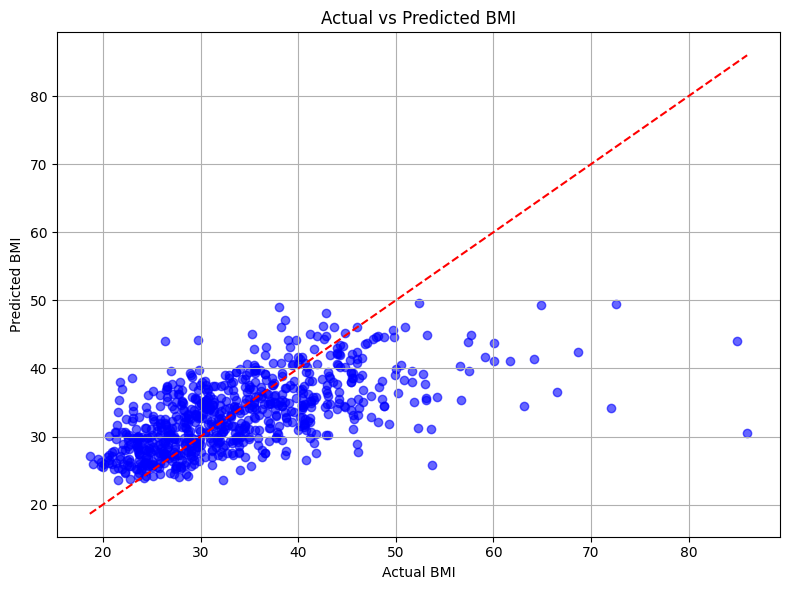

In [ ]:
X_test = np.array(testing_embeddings)
y_test = np.array(testing_labels)

y_pred = best_bmi_model.predict(X_test)

saved_model_file_name =f'saved_models/best_bmi_model_{datetime.now()}.joblib'

joblib.dump(best_bmi_model, saved_model_file_name)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

In [ ]:
xgboost_dataframe_results = pd.DataFrame({
    'filename': testing_filenames,
    'actual_bmi': y_test,
    'predicted_bmi': y_pred
})
xgboost_dataframe_results.to_csv("bmi_test_results.csv", index=False)

In [ ]:
xgboost_dataframe_results.head()

,filename,actual_bmi,predicted_bmi
0,img_3373.bmp,27.891291,38.028904
1,img_3378.bmp,60.096828,43.763538
2,img_3372.bmp,36.258679,34.008755
3,img_3371.bmp,24.389796,24.221573
4,img_3375.bmp,23.370844,31.175821
